# 6. Some more features

We quickly summarize here some more features that might be of interest even for beginners.

In [1]:
from dask.distributed import Client

client = Client()#"tcp://127.0.0.1:63517")
client

Client Scheduler: tcp://127.0.0.1:61246 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Calculating multiple outputs

Sometimes we need multiple outputs from a computation. However until now all we have seen are series of delayed computations and final ```compute()``` call. It is however possible to recover **multiple** intermediate results and to do that **without computational penalty**. Let's consider this example:

In [2]:
import dask
import dask.array as da

In [3]:
my_array = da.random.random((500,1000,250))

In [4]:
my_array

dask.array<random_sample, shape=(500, 1000, 250), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

We want to calculate the difference between max and min projections along the third axis. But we also want to check the maximum projection.

In [5]:
maxproj = my_array.min(axis = 2)
meanproj = my_array.mean(axis = 2)
difference = maxproj - meanproj

If we caclulate things separately, the maximum projection is done twice:

In [6]:
%%time
maxp = maxproj.compute()
diffp = difference.compute()

CPU times: user 160 ms, sys: 23.9 ms, total: 184 ms
Wall time: 1.65 s


Whereas with ```dask.compute``` we do it only once because Dask knows to smartly re-use computations:

In [7]:
%%time
result = dask.compute(maxproj, difference)

CPU times: user 106 ms, sys: 18 ms, total: 124 ms
Wall time: 745 ms


In [8]:
result[0].shape

(500, 1000)

In [9]:
result[1].shape

(500, 1000)

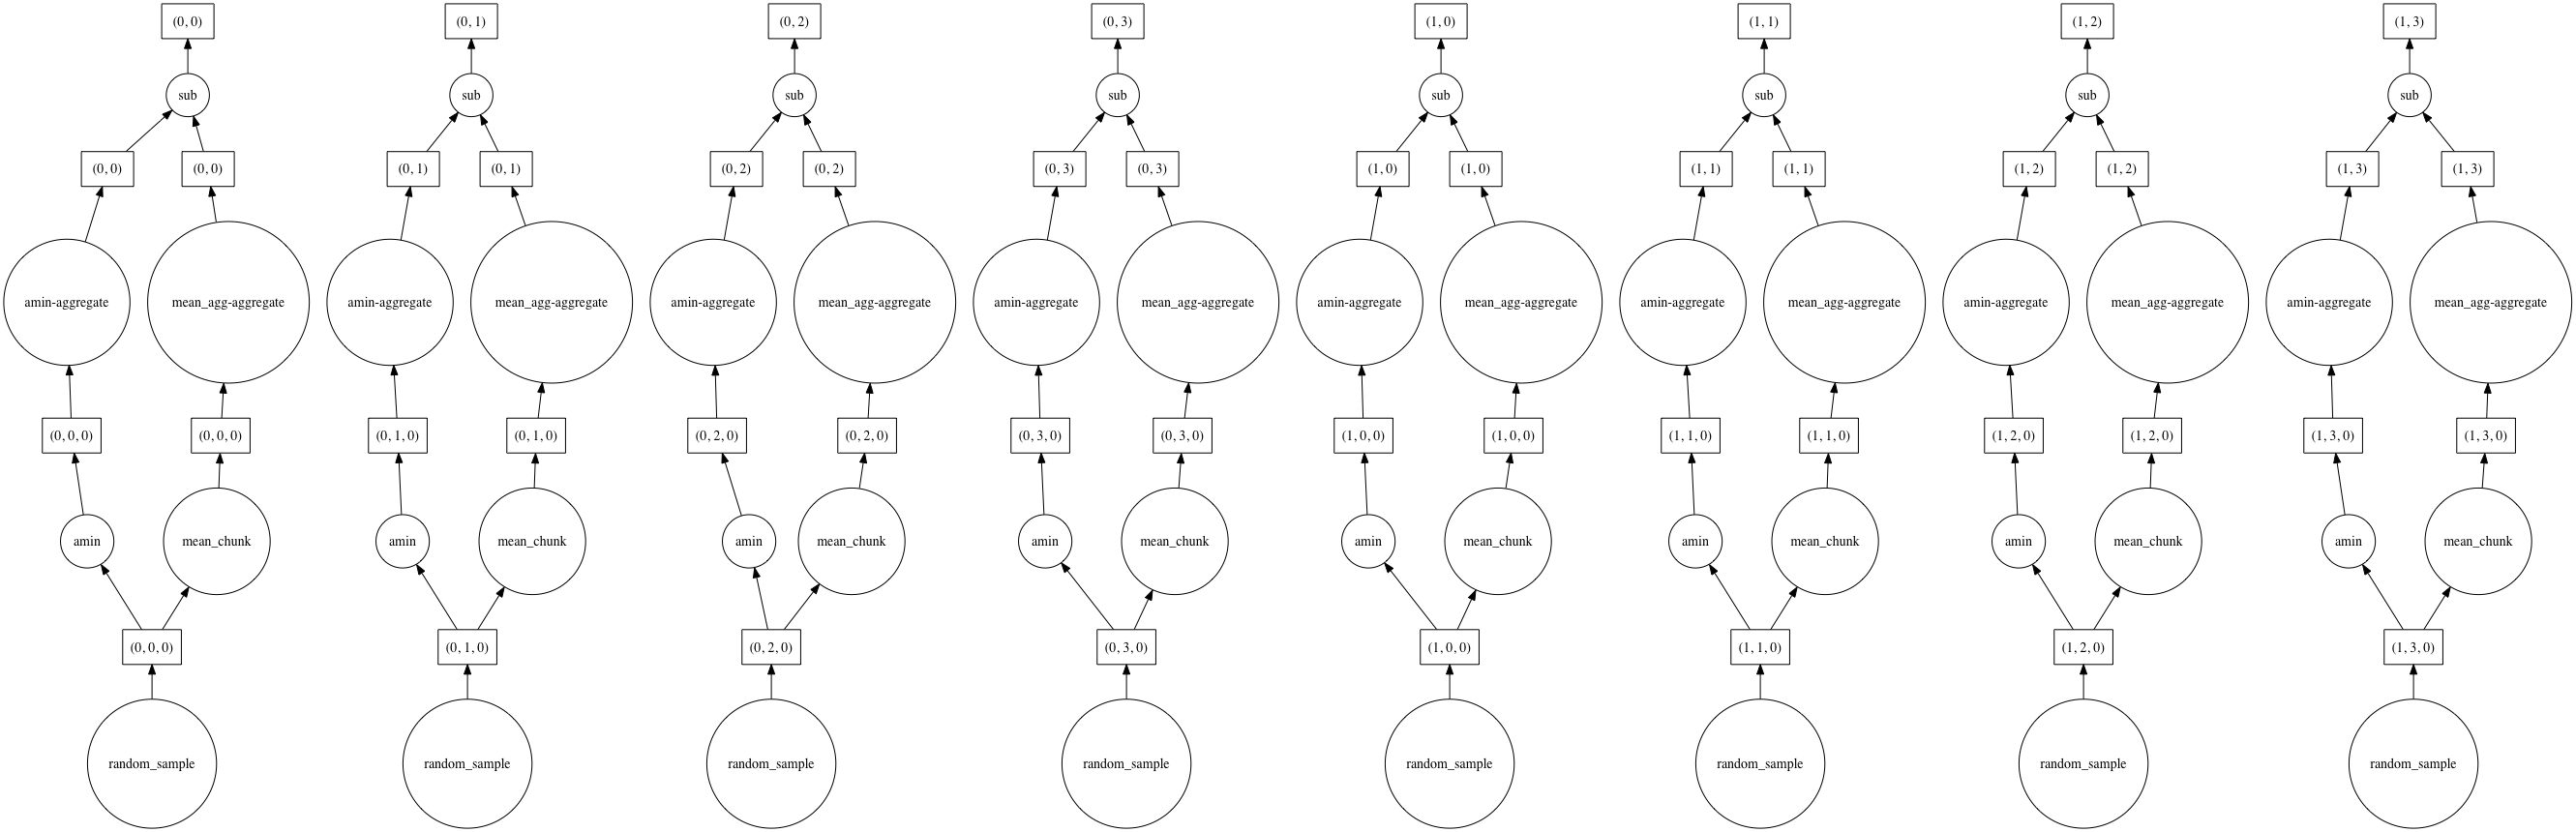

In [10]:
dask.visualize(maxproj, difference)

Also more generally, ```dask.compute()``` can be used to recover lists of computations e.g. from a series of ```dask.delayed``` calls:

In [11]:
def fun(x):
    return x**2
results = [dask.delayed(fun)(x) for x in range(5)]

In [12]:
results

[Delayed('fun-08a4912e-a454-4bbe-8e3f-7d8b3ef53d7b'),
 Delayed('fun-9bcc473e-4f1c-48b1-92d7-2e9440e7e95a'),
 Delayed('fun-fb8023c5-5a6b-4cfc-98d8-9ae9cf7c4173'),
 Delayed('fun-16c6a7bf-f5fc-4567-ab02-b7e66b7c7ccc'),
 Delayed('fun-a8d2c96f-acba-43a3-a41e-989f8cd089a8')]

In [13]:
result_computed = dask.compute(results)

In [14]:
result_computed

([0, 1, 4, 9, 16],)

## Delayed as decorators

We have seen that we can use ```delayed()``` to create Dask versions of regular functions, and use it like this:

In [15]:
from dask import delayed

In [16]:
def inc(x):
    return x+1

In [17]:
val = delayed(inc)(10)

In [18]:
val.compute()

11

If we need to re-use that same function multiple times and we want to avoid using ```delayed()``` over and over, or if we want a simple way to run code with or without dask we can use ```delayed()``` as a decorator since it is applied to a **function**:

In [19]:
@delayed
def inc2(x):
    return x+1

In [20]:
val = inc2(10)

In [21]:
val

Delayed('inc2-ac8b146a-780d-42c9-b69d-e0e038fd105d')

## Dask bags

There's one more "container" type like dask-arrays and dask-dataframes that one can use: the dask bag. It is mainly used to handle unstructured data or semi-structured data. These are very specific applications, so we won't go into details. However one can also create a dask-bag e.g. from a list:

In [22]:
import dask.bag as db
import numpy as np

In [23]:
mylist = np.random.random(1000000)

In [24]:
my_bag = db.from_sequence(mylist, partition_size=100)

Then one can do standard operations like map, groupby etc.:

In [25]:
squared = my_bag.map(lambda x:x**2).compute()

As you see this is not particularly efficient. One should use bags mostly to import data and then transform the input into a dask-array or -dataframe.

## Peristing in memory

Until now, the only time where we actually accessed the data was when calling ```compute()```. If at some point we have a dask object that fits into RAM and that we don't want to recalculate everytime, we can make it **persist**. For example let's create a large array:

In [26]:
my_array = da.random.random((1000,1000,2500))

In [27]:
my_array

dask.array<random_sample, shape=(1000, 1000, 2500), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

Now we want to do a maximum projection along an axis and then calcualte the average of that projection:

In [28]:
max_proj = my_array.max(axis = 2)
meanval = max_proj.mean()
meanval.compute()

0.9996005444406264

Now we have our mean values. But what if later we need again the maximum projection? Currently it's still a dask array:

In [29]:
max_proj

dask.array<amax-aggregate, shape=(1000, 1000), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

So if we want to access a given element of the resulting matrix, Dask has to perfrom the whole calculation again:

In [30]:
%%time
max_proj[0,0].compute()

CPU times: user 62.7 ms, sys: 6.88 ms, total: 69.6 ms
Wall time: 819 ms


0.9999719671803785

Now we can make this object **persist**:

In [31]:
max_proj = max_proj.persist()

The object is still as dask object, so we can still use it in further calculations:

In [32]:
max_proj

dask.array<amax-aggregate, shape=(1000, 1000), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

Let's integrate that ```persist``` command in our previous routine:

In [33]:
max_proj = my_array.max(axis = 2).persist()
meanval = max_proj.mean()
meanval.compute()

0.9996005444406264

And now let's recover a single value from that array:

In [34]:
%%time
max_proj[0,0].compute()

CPU times: user 7.92 ms, sys: 2.1 ms, total: 10 ms
Wall time: 20.1 ms


0.9999719671803785

Now the time is 9ms instead of 600ms because the object already exists! This of course only works for objects small enough to hold in RAM.